In [1]:
# !pip install pickle5
# %cd /content/drive/MyDrive/Colab\ Notebooks

In [2]:
import pandas as pd
import numpy as np
import pickle as pickle
from matplotlib import pyplot as plt

from Network import Net
from utils import *

In [3]:
train = pd.read_parquet('out/train.parquet')
test = pd.read_parquet('out/test.parquet')

In [4]:
# number of events in train and test data
train.shape, test.shape

((163955180, 4), (7683577, 4))

In [5]:
train.head(5)

,session,aid,ts,type
0,0,1517085,1659304800,0
1,0,1563459,1659304904,0
2,0,1309446,1659367439,0
3,0,16246,1659367719,0
4,0,1781822,1659367871,0


In [6]:
# number of sessions in train and test data
train.session.unique().shape[0], test.session.unique().shape[0]

(11098528, 1801251)

In [7]:
# number of unique items in train and test data
train.aid.unique().shape[0], test.aid.unique().shape[0]

(1825499, 874852)

<AxesSubplot:>

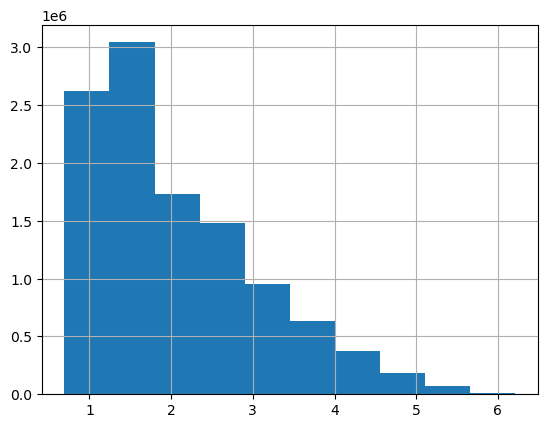

In [8]:
# events per session in train data 
train.groupby('session')['aid'].count().apply(np.log1p).hist()

<AxesSubplot:>

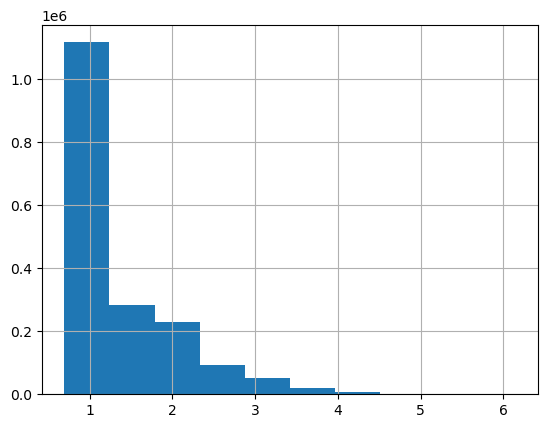

In [9]:
# events per session in test data
test.groupby('session')['aid'].count().apply(np.log1p).hist()

In [10]:
# number of click type 
print('clicks:', sum(train.type == 0), end = ','), print('clicks:', sum(test.type == 0))
print('carts:', sum(train.type == 1), end = ','), print('carts:', sum(test.type == 1))
print('orders:', sum(train.type == 2), end = ','), print('orders:', sum(test.type == 2))

clicks: 147407286,clicks: 6958277
carts: 12681932,carts: 650768
orders: 3865962,orders: 74532


(None, None)

In [11]:
test.groupby('session')['aid'].count().describe()

count    1.801251e+06
mean     4.265689e+00
std      8.381265e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      4.650000e+02
Name: aid, dtype: float64

In [12]:
train.session.max(), test.session.min()

(11098527, 11098528)

In [13]:
len(set(test.aid.tolist())) - len(set(train.aid.tolist()))

-950647

In [14]:
test_mode = False
encoder_len = 50
decoder_len = 20
chunks = pd.read_json('out/train_sessions.jsonl', lines=True, chunksize = 128)

In [15]:
word2vec = Word2Vec.load("Models/word2vec.model")

In [16]:
net = Net(en_len=encoder_len, de_len=decoder_len,
          embed_vector_size=128,
          embedding_matrix=word2vec.wv.vectors,
          vocab_size=len(word2vec.wv.index_to_key))

model, encoder_model, decoder_model = net.create_bidirectional_model(256)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    236068480   ['input_1[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None, 4)]    0           []                           

In [ ]:
train_loss_results = []
# Include the epoch in the file name (uses `str.format`)
checkpoint_path_model = "Models/model-{epoch:03d}.ckpt"
checkpoint_dir_model = os.path.dirname(checkpoint_path_model)
if not test_mode:
    num_epochs = 50
    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.BinaryAccuracy()
        epoch_recall = tf.keras.metrics.Recall()
        epoch_precision = tf.keras.metrics.Precision()
        i = 0
        for chunk in chunks:
            i += 1
            if i > 10:
                break

            # print(chunk.head(10))
            session_AIDs = chunk.apply((lambda x: [row['aid'] for row in x['events']]), axis=1)
            # print(session_AIDs.head(10))
            session_types = chunk.apply((lambda x: [row['type'] for row in x['events']]), axis=1)
            # print(session_types.head(10))
            X_en, Type_en, X_de, Type_x_de, Y_de, Type_y_de = create_word2vec_training_data(session_AIDs, session_types, word2vec,
                                                                                            interval_size=[encoder_len, decoder_len])

            for j in range(100):
                # Optimize the model
                loss_value, grads = net.grad(model, [X_en, Type_en, X_de, Type_x_de], np.concatenate([Y_de, Type_y_de], axis=-1))
                net.optimizer.apply_gradients(zip(grads, model.trainable_variables))
                print(loss_value, end='\r')

            # Track progress
            epoch_loss_avg.update_state(loss_value)  # Add current batch loss

        # End epoch
        train_loss_results.append(epoch_loss_avg.result())


        if epoch % 1 == 0:
            print("\n Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

        # if epoch % 5 == 0:
        #     # Save the weights using the `checkpoint_path` format
        #     model.save_weights(checkpoint_path_model.format(epoch=epoch))


tf.Tensor(1.1946160080117412, shape=(), dtype=float64)
 Epoch 000: Loss: 1.706
tf.Tensor(0.9477410247635502, shape=(), dtype=float64)
 Epoch 001: Loss: 1.062
tf.Tensor(1.0682389820095082, shape=(), dtype=float64)
 Epoch 002: Loss: 1.011
tf.Tensor(1.0342521330754606, shape=(), dtype=float64)
 Epoch 003: Loss: 1.014
tf.Tensor(1.0202228446326649, shape=(), dtype=float64)
 Epoch 004: Loss: 1.012
tf.Tensor(0.9609766085930506, shape=(), dtype=float64)
 Epoch 005: Loss: 0.930
tf.Tensor(0.8456096649984713, shape=(), dtype=float64)
 Epoch 006: Loss: 0.956
tf.Tensor(1.0721256916173543, shape=(), dtype=float64)
 Epoch 007: Loss: 0.947
tf.Tensor(1.0080377397638434, shape=(), dtype=float64)
 Epoch 008: Loss: 0.942
tf.Tensor(1.0645259960228985, shape=(), dtype=float64)
 Epoch 009: Loss: 0.994
tf.Tensor(0.8984246622615742, shape=(), dtype=float64)
 Epoch 010: Loss: 1.010
tf.Tensor(1.0144814656214007, shape=(), dtype=float64)
 Epoch 011: Loss: 0.982
tf.Tensor(1.2114741008483274, shape=(), dtype=float6

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_loss_results, label='loss')
plt.legend()
plt.xlabel("epochs")
plt.show()

In [ ]:
if checkpoint_dir_model:
    # latest_model = tf.train.latest_checkpoint(checkpoint_dir_model)
     # net.model.get_layer('embedding').set_weights([word2vec.wv.vectors])
    # net.model.load_weights(latest_model)
    prediction('out/test_sessions.jsonl',
               net.model,
               encoder_model,
               decoder_model,
               word2vec,
               interval_size=[encoder_len, decoder_len])

In [ ]:
from pathlib import Path
import evaluate
evaluate.main(Path('out/test_labels.jsonl'), Path('out/prediction.csv'))